## **Setting up the environment**

In [ ]:
#Libraries needed in this notebook
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import timeSeriesMatrix

data = np.loadtxt("/content/timeseriesuptodec.csv", delimiter=',')

In [ ]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=cfa46f2bc9d9075fe781f8ac9a2b14e88167dad109971c40efe0f33461f69163
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
regions_with_minimum_taxi_trips = [[26, 365168.0], [53, 26872.0], [60, 459962.0], [62, 15995.0], [65, 18050.0], [66, 2536978.0], [67, 21184.0], [68, 59604.0], [72, 750790.0], [73, 96074.0], [75, 155855.0], [76, 716215.0], [77, 1399092.0], [78, 496385.0], [80, 30788.0], [82, 64346.0], [83, 427156.0], [88, 86480.0], [100, 62372.0], [125, 107300.0]]

regions_selected_array = []

for elem in regions_with_minimum_taxi_trips:
  regions_selected_array.append(elem[0])

print("List of region IDs with minimum taxi trips and representing 98% of all taxi flows")
print(regions_selected_array)

List of region IDs with minimum taxi trips and representing 98% of all taxi flows
[26, 53, 60, 62, 65, 66, 67, 68, 72, 73, 75, 76, 77, 78, 80, 82, 83, 88, 100, 125]
time: 5.51 ms


In [ ]:
import timeSeriesAnalysis

newFlowTimeSeriesMatrix = timeSeriesAnalysis.returnNewFlowTimeSeriesMatrix(data)
endFlowTimeSeriesMatrix = timeSeriesAnalysis.returnEndFlowTimeSeriesMatrix(data)

time: 572 ms


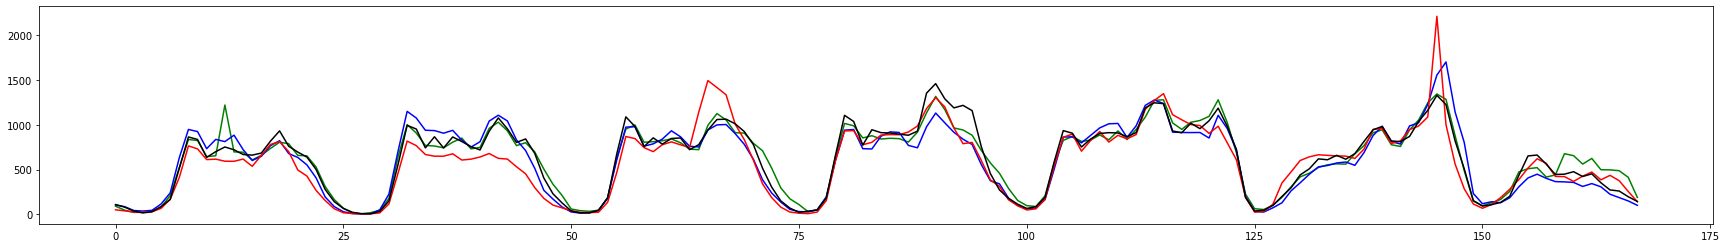

time: 214 ms


In [ ]:
regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(66)

plt.plot( newFlowTimeSeriesMatrix[regionIDIndex][24*288:24*295], 'g', newFlowTimeSeriesMatrix[regionIDIndex][24*295:24*302],'b', newFlowTimeSeriesMatrix[regionIDIndex][24*302:24*309], 'r', newFlowTimeSeriesMatrix[regionIDIndex][24*309:24*316], 'black')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

In [ ]:
def returnRMSEFor(timeSeriesForecast, timeSeriesReal):
  n = len(timeSeriesForecast)
  if len(timeSeriesReal) != n:
    print("error : RMSE , not same sizes arrays")
    return -1
  i = 0 
  mse = 0
  while i < n:
    if timeSeriesForecast[i] < 0:
      timeSeriesForecast[i] = 0
    mse = mse + (timeSeriesForecast[i] - timeSeriesReal[i])**2
    i = i + 1
  rmse = (mse/n)**0.5
  return rmse

time: 5.01 ms


## **Exogenous variables**

In [ ]:
!pip install holidays

time: 3.3 s


In [ ]:
import datetime
from datetime import date
from datetime import timedelta

import holidays

us_holidays = holidays.UnitedStates()

holidayEncoding = 0

#array containing the hour for each index for year 2017
def retourHourArray(initialDate, timeRangeInHours = 24*365):
  hoursinaDayVector = [ i for i in range(0, 24)]
  hoursinYear2017Array = hoursinaDayVector * int(timeRangeInHours/24)
  return hoursinYear2017Array

#returns 1 if the day is a US holiday, 0 if not
def isDateaHoliday(dateValue):
  if dateValue in us_holidays:
    return 1
  return 0

#returns the value of the day in the week (Monday:1, ..., Sunday:7)
def returndayTypeEncoding(dateValue):
  return date(dateValue.year,dateValue.month,dateValue.day ).isoweekday()

#returns the index of the day for each hour in the year corresponding to the index
def returnDayTypeArray(initialDate, timeRangeInHours = 24*365):
  dayTypeEncodingArray = []
  initialDateofArray = datetime.datetime.strptime(initialDate, "%Y-%m-%d")
  i = 0
  numberOfDays, remainingHours = divmod(timeRangeInHours, 24)

  while i < numberOfDays: 
    newDate = initialDateofArray + datetime.timedelta(days=i)
    newDateEncoding = returndayTypeEncoding(newDate)
    newArrayToAdd = [newDateEncoding] * 24
    dayTypeEncodingArray = dayTypeEncodingArray + newArrayToAdd
    i = i + 1
  
  if remainingHours > 0:
    newDate = initialDateofArray + datetime.timedelta(days=i)
    newDateEncoding = returndayTypeEncoding(newDate)
    newArrayToAdd = [newDateEncoding] * remainingHours
    dayTypeEncodingArray = dayTypeEncodingArray + newArrayToAdd
  
  return dayTypeEncodingArray

time: 38.6 ms


In [ ]:
dayTypeEncoding2017 = returnDayTypeArray("2017-01-01")
hourArray = retourHourArray("2017-01-01")

time: 9.48 ms


In [ ]:
print(dayTypeEncoding2017[24*307:24*307+1])

[6]
time: 1.48 ms


## **LSTM on univariate time series**

The region ID 66 is the busiest one in Chicago with 2.5 million new-flows and end-flows combined, from January to end of March 2017. 

So it's the best candidate on which we try the LSTM model. If we get relatively good results in comparison to the statistical models used in the previous work, we would probably get good results on the other regions. 

In this first model, we use a simple model containing 2 months of training data (September to October 2017), and we try to predict the taxi new-flows for the month of November 2017. Also, we add an array containing the index of the day at each time. The index takes value of 1 if the timestamp falls on a Monday, 2 if it's Tuesday, up to 7 if it falls on a Sunday.

In [ ]:
from numpy import array

regionIDSelected = 66

startIndex = 24*240
endIndex = 24*303
prediction_range = 24*7*2

regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

y_to_train = array(newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex])
y_to_test = array(newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+prediction_range])

y_to_train = y_to_train.reshape(-1, 1)
y_to_test = y_to_test.reshape(-1, 1)

#first feature
weekday_to_train = dayTypeEncoding2017[startIndex:endIndex]
weekday_to_test = dayTypeEncoding2017[endIndex:endIndex+prediction_range]

#second feature
hourArray_to_train = hourArray[startIndex:endIndex]
hourArray_to_test = hourArray[endIndex:endIndex+prediction_range]

time: 8.78 ms


**Data scaling**

For the LSTM, we do data scaling on the taxi trips. The data scaling and centering will be done on the training set only, since it computes the mean and standard deviation. Using those values we then perform the transformation (scaling and centering) on the test data. That way the LSTM model will never see the data on the test set.

We leave the external features as they are. It's not necessary to transform them since they are categorical values, and have no meaning in terms of numerical value (except the order). In addition, if we were to transform those features, we would get floats instead of interger values, and thus will take unnecessary memory space.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(y_to_train)
scaled_train_data = scaler.transform(y_to_train)
scaled_test_data = scaler.transform(y_to_test)

time: 452 ms


Below we print the taxi trips for region ID 66 for the first 2 hours of the training set. The values are scaled in the range [-1,1] and centered around the mean, and scaled.

In [ ]:
scaled_train_data[:2]

array([[0.04862332],
       [0.02519039]])

time: 4.67 ms


In [ ]:
len(scaled_train_data)

1512

time: 7.73 ms


In [ ]:
my_array = scaled_train_data[:]

#my_array[:][:][:].shape
#my_array = my_array[:][:][:]
my_array = my_array.reshape(1512,)

scaled_train_data_input = np.stack((my_array, weekday_to_train, hourArray_to_train), axis=1)

time: 2.85 ms


Printing the first 2 hours again, we now have two additional columns. The first one with value 2 represents the day 2 of the week, meaning a Tuesday. The 3rd column represents the hour. New-flows of taxis for region ID 66 at midnight and 1AM are shown below.

In [ ]:
scaled_train_data_input[:2]

array([[0.04862332, 2.        , 0.        ],
       [0.02519039, 2.        , 1.        ]])

time: 3.34 ms


In [ ]:
#to remove
scaled_train_data_input[:1]
scaled_train_data_input.shape

(1512, 3)

time: 5.44 ms


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 24
n_features= 3
generator = TimeseriesGenerator(scaled_train_data_input, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 200)               163200    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 201       
Total params: 163,401
Trainable params: 163,401
Non-trainable params: 0
_________________________________________________________________
time: 206 ms


In [ ]:
lstm_model.fit_generator(generator,epochs=10)

Epoch 1/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0021
Epoch 2/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0020
Epoch 3/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0021
Epoch 4/10
1488/1488 [==============================] - 30s 20ms/step - loss: 0.0020
Epoch 5/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0019
Epoch 6/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0019
Epoch 7/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0020
Epoch 8/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0019
Epoch 9/10
1488/1488 [==============================] - 31s 21ms/step - loss: 0.0019
Epoch 10/10
1488/1488 [==============================] - 36s 24ms/step - loss: 0.0019


time: 5min 14s


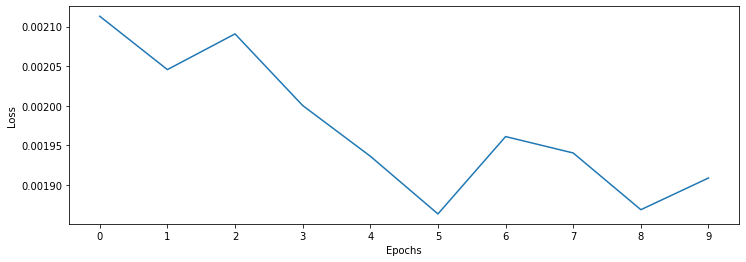

time: 208 ms


In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

**With 1 feature:**

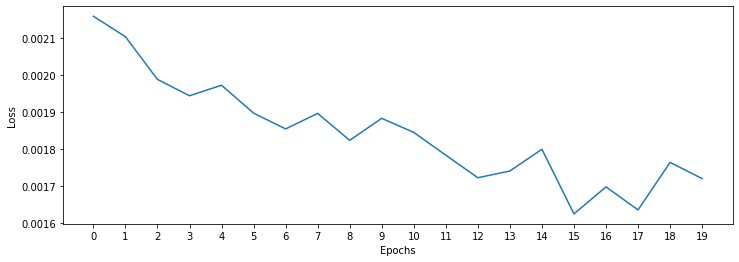

time: 240 ms


In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

**With 1 feature:**

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data_input[-n_input:]

current_batch = batch.reshape((-1, n_input, n_features))

j = 0
for i in range(len(weekday_to_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    elem = np.array([lstm_pred[0], weekday_to_test[j]])
    elem = elem.reshape((1, 2))

    lstm_predictions_scaled.append(lstm_pred) 

    current_batch = np.append(current_batch[0] , elem, axis = 0)
    current_batch = current_batch[1:]
    current_batch = current_batch.reshape((-1, n_input, n_features))
    j = j + 1

#we scale back the prediction to get the number of taxis per hour
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

time: 3.95 s


**With 2 features**

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data_input[-n_input:]

current_batch = batch.reshape((-1, n_input, n_features))

j = 0
for i in range(len(weekday_to_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    elem = np.array([lstm_pred[0], weekday_to_test[j], hourArray_to_test[j]])
    elem = elem.reshape((1, 3))

    lstm_predictions_scaled.append(lstm_pred) 

    current_batch = np.append(current_batch[0] , elem, axis = 0)
    current_batch = current_batch[1:]
    current_batch = current_batch.reshape((-1, n_input, n_features))
    j = j + 1

#we scale back the prediction to get the number of taxis per hour
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

time: 884 ms


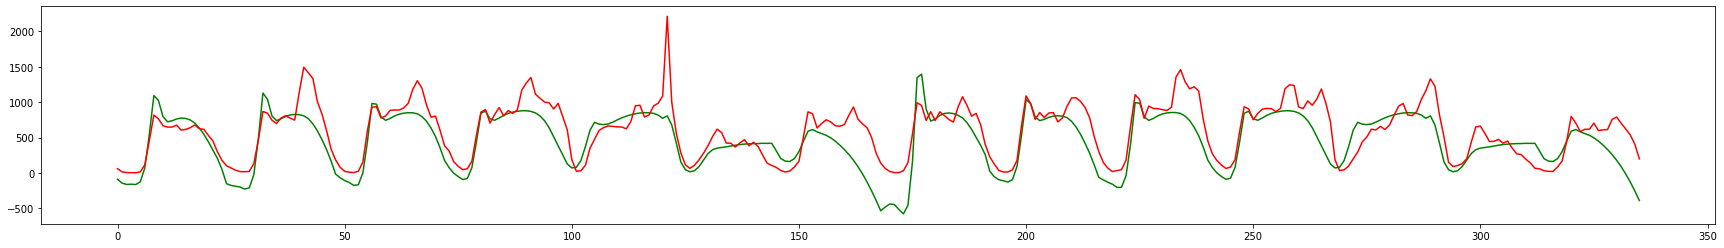

time: 206 ms


In [ ]:
plt.plot( lstm_predictions, 'g', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

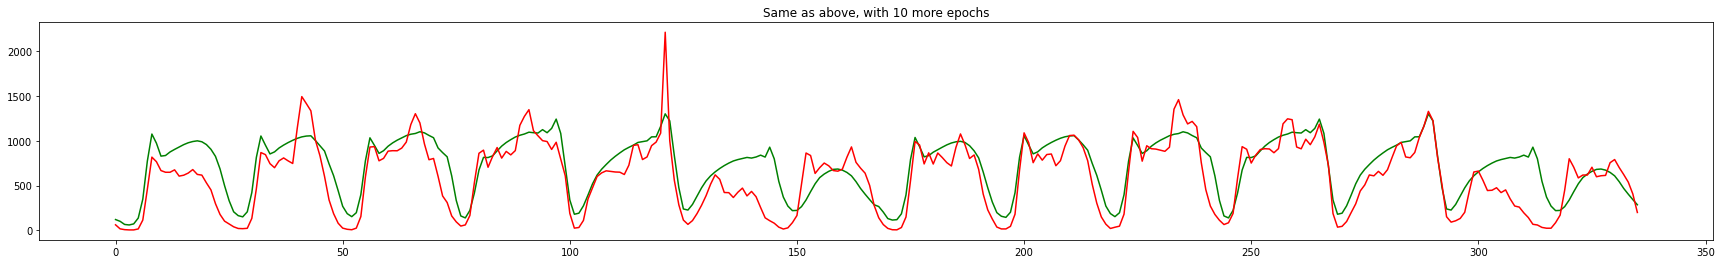

time: 224 ms


In [ ]:
plt.title("Same as above, with 10 more epochs")
plt.plot( lstm_predictions, 'g', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

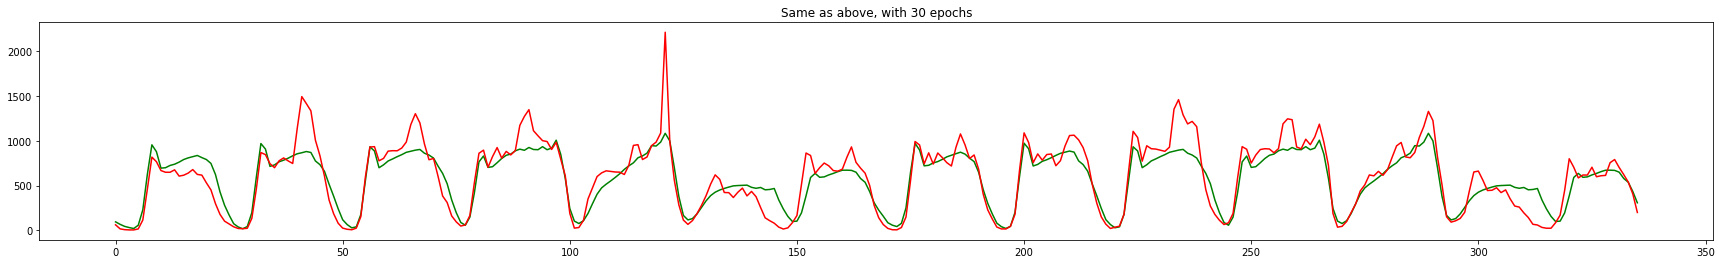

time: 212 ms


In [ ]:
plt.title("Same as above, with 30 epochs")
plt.plot( lstm_predictions, 'g', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

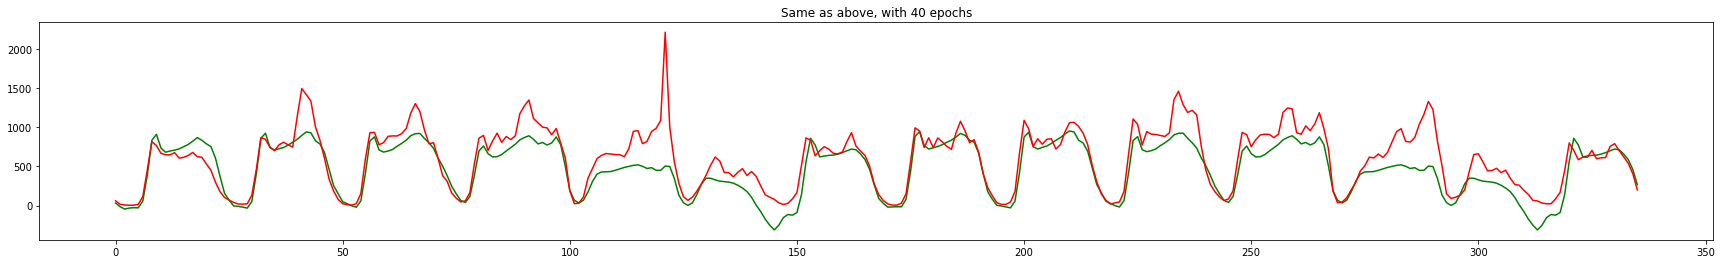

time: 205 ms


In [ ]:
plt.title("Same as above, with 40 epochs")
plt.plot( lstm_predictions, 'g', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

In [ ]:
rmse = returnRMSEFor(y_to_test, lstm_predictions)
print("rmse with 10 epochs, with 2 features: day index and hour")
print(rmse)

rmse with 10 epochs, with 2 features: day index and hour
[288.34445778]
time: 3.53 ms


In [ ]:
rmse = returnRMSEFor(y_to_test, lstm_predictions)
print("rmse with 20 epochs, with 2 features: day index and hour")
print(rmse)

rmse with 20 epochs, with 2 features: day index and hour
[242.97339679]
time: 4.49 ms


In [ ]:
import statsfunctions
rmse = returnRMSEFor(y_to_test, lstm_predictions)
mae = statsfunctions.returnMAEFor(y_to_test, lstm_predictions)
print("RMSE with 30 epochs, with 2 features: day index and hour")
print(rmse)
print("MAE with 30 epochs, with 2 features: day index and hour")
print(mae)

RMSE with 30 epochs, with 2 features: day index and hour
[169.39331517]
MAE with 30 epochs, with 2 features: day index and hour
[116.97754996]
time: 13.1 ms


In [ ]:
rmse = returnRMSEFor(y_to_test, lstm_predictions)
mae = statsfunctions.returnMAEFor(y_to_test, lstm_predictions)
print("RMSE with 40 epochs, with 2 features: day index and hour")
print(rmse)
print("MAE with 40 epochs, with 2 features: day index and hour")
print(mae)

RMSE with 40 epochs, with 2 features: day index and hour
[229.96730684]
MAE with 40 epochs, with 2 features: day index and hour
[160.73368154]
time: 4.81 ms


After 40 epochs, the RMSE and MAE increased a lot, meaning the model overfit the training data.

**WIth 1 feature:**

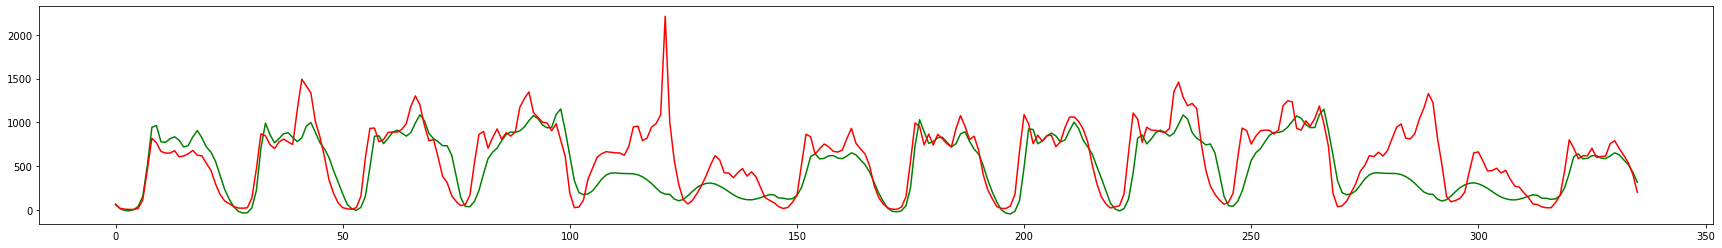

time: 198 ms


In [ ]:
plt.plot( lstm_predictions, 'g', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

In [ ]:
rmse = returnRMSEFor(y_to_test, lstm_predictions)

print(rmse)

[288.11533738]
time: 2.98 ms


In [ ]:
#DONT USE THIS CODE CELL
# this code assumes no feature

lstm_predictions_scaled = list()

batch = scaled_train_data_input[-n_input:]

print(batch[:2])

current_batch = batch.reshape((-1, n_input, n_features))
current_batch[0][:] = batch

for i in range(24*7*4):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    print(lstm_pred[0])
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

## **Testing with other time range for training on a single region**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#data parameters
startIndex = 24*236
endIndex = 24*299 #303
period_to_forecast = 24*7*2

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#LSTM Parameters
#n_input = 4
sequence_length = 10
n_features= 3
batch_size = 1
number_epochs = 25
hidden_states = 220

print("Univariate time series")
print("New-flows forecasting")

for region in [66]:
  #NEW-FLOW
  #getting the data for the region only
  y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test = returnTrainTestTimeseriesWith2features(region, data, startIndex, endIndex, period_to_forecast) 

  #Scaling and centering
  scaler = MinMaxScaler()
  scaler.fit(y_to_train)
  scaled_train_data = scaler.transform(y_to_train)
  #scaled_test_data = scaler.transform(y_to_test) #not needed

  #input reshaping to include features
  scaled_train_data_copy = scaled_train_data[:]
  scaled_train_data_copy = scaled_train_data_copy.reshape(len(scaled_train_data),)
  scaled_train_data_input = np.stack((scaled_train_data_copy, weekday_to_train, hourArray_to_train), axis=1)

  #creating instance of LSTM model
  lstm_model, generator = returnLSTMModel(sequence_length, scaled_train_data_input, scaled_train_data, batch_size, n_features, hidden_states)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs)

  #forecast
  lstm_predictions_scaled = returnLSTMForecast(lstm_model, sequence_length, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

  j = 0
  rmseArrayValues = []
  while j < len(rmseForecastingPeriodArrays):
    forecastEndIndex = rmseForecastingPeriodArrays[j]
    rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
    rmseArrayValues.append(rmseValue[0])
    j = j + 1
  print("RMSE for region ID :", region)
  print("Hours:", rmseForecastingPeriodArrays)
  print("Values :", rmseArrayValues)
  print()

Univariate time series
New-flows forecasting
Epoch 1/25
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0219
Epoch 2/25
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0086
Epoch 3/25
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0064
Epoch 4/25
1502/1502 [==============================] - 20s 13ms/step - loss: 0.0050
Epoch 5/25
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0041
Epoch 6/25
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0038
Epoch 7/25
1502/1502 [==============================] - 19s 12ms/step - loss: 0.0033
Epoch 8/25
1502/1502 [==============================] - 20s 13ms/step - loss: 0.0032
Epoch 9/25
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0031
Epoch 10/25
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0030
Epoch 11/25
1502/1502 [==============================] - 18s 12ms/step - loss: 0.0029
Epoch 12/25
1502/1

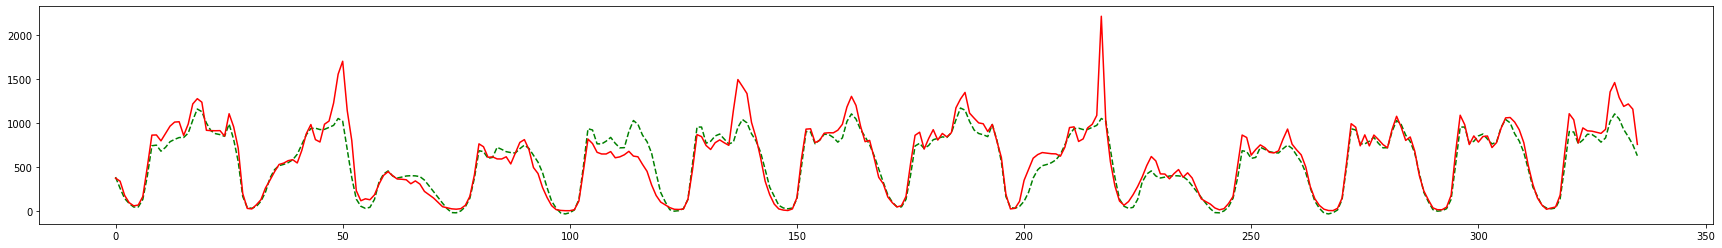

time: 211 ms


In [ ]:
plt.plot( lstm_predictions, 'g--', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

In [ ]:
lstm_model.fit_generator(generator, epochs=5)

#forecast
lstm_predictions_scaled = returnLSTMForecast(lstm_model, sequence_length, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

j = 0
rmseArrayValues = []
while j < len(rmseForecastingPeriodArrays):
  forecastEndIndex = rmseForecastingPeriodArrays[j]
  rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
  rmseArrayValues.append(rmseValue[0])
  j = j + 1
print("RMSE for region ID :", region)
print("Hours:", rmseForecastingPeriodArrays)
print("Values :", rmseArrayValues)
print()

Epoch 1/5
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0016
Epoch 2/5
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0015
Epoch 3/5
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0015
Epoch 4/5
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0015
Epoch 5/5
1502/1502 [==============================] - 19s 13ms/step - loss: 0.0015
RMSE for region ID : 66
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [40.18575272286319, 69.2169023006115, 84.79890010984077, 108.60456920493762, 113.7155620268881, 105.800751275013, 147.70119992808657, 142.68953542328063]

time: 1min 37s


## **More epochs and experimenting**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#data parameters
startIndex = 24*233
endIndex = 24*303 #303
period_to_forecast = 24*7*2

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#LSTM Parameters
#n_input = 4
sequence_length = 24
n_features= 3
batch_size = 1
number_epochs = 35
hidden_states = 280

print("Univariate time series")
print("New-flows forecasting")

for region in [66]:
  #NEW-FLOW
  #getting the data for the region only
  y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test = returnTrainTestTimeseriesWith2features(region, data, startIndex, endIndex, period_to_forecast) 

  #Scaling and centering
  scaler = MinMaxScaler()
  scaler.fit(y_to_train)
  scaled_train_data = scaler.transform(y_to_train)
  #scaled_test_data = scaler.transform(y_to_test) #not needed

  #input reshaping to include features
  scaled_train_data_copy = scaled_train_data[:]
  scaled_train_data_copy = scaled_train_data_copy.reshape(len(scaled_train_data),)
  scaled_train_data_input = np.stack((scaled_train_data_copy, weekday_to_train, hourArray_to_train), axis=1)

  #creating instance of LSTM model
  lstm_model, generator = returnLSTMModel(sequence_length, scaled_train_data_input, scaled_train_data, batch_size, n_features, hidden_states)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs)

  #forecast
  lstm_predictions_scaled = returnLSTMForecast(lstm_model, sequence_length, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

  j = 0
  rmseArrayValues = []
  while j < len(rmseForecastingPeriodArrays):
    forecastEndIndex = rmseForecastingPeriodArrays[j]
    rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
    rmseArrayValues.append(rmseValue[0])
    j = j + 1
  print("RMSE for region ID :", region)
  print("Hours:", rmseForecastingPeriodArrays)
  print("Values :", rmseArrayValues)
  print()

Univariate time series
New-flows forecasting
Epoch 1/35
1656/1656 [==============================] - 51s 31ms/step - loss: 0.0216
Epoch 2/35
1656/1656 [==============================] - 52s 31ms/step - loss: 0.0074
Epoch 3/35
1656/1656 [==============================] - 51s 31ms/step - loss: 0.0056
Epoch 4/35
1656/1656 [==============================] - 53s 32ms/step - loss: 0.0041
Epoch 5/35
1656/1656 [==============================] - 50s 30ms/step - loss: 0.0040
Epoch 6/35
1656/1656 [==============================] - 50s 30ms/step - loss: 0.0034
Epoch 7/35
1656/1656 [==============================] - 51s 31ms/step - loss: 0.0032
Epoch 8/35
1656/1656 [==============================] - 50s 30ms/step - loss: 0.0031
Epoch 9/35
1656/1656 [==============================] - 51s 31ms/step - loss: 0.0029
Epoch 10/35
1656/1656 [==============================] - 52s 32ms/step - loss: 0.0029
Epoch 11/35
1656/1656 [==============================] - 51s 31ms/step - loss: 0.0027
Epoch 12/35
1656/1

## **Trying Bidirectional LSTM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#data parameters
startIndex = 24*236
endIndex = 24*299 #303
period_to_forecast = 24*7*2

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#LSTM Parameters
#n_input = 4
sequence_length = 24
n_features= 3
batch_size = 1
number_epochs = 25
hidden_states = 350

print("Univariate time series")
print("New-flows forecasting")

for region in [66]:
  #NEW-FLOW
  #getting the data for the region only
  y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test = returnTrainTestTimeseriesWith2features(region, data, startIndex, endIndex, period_to_forecast) 

  #Scaling and centering
  scaler = MinMaxScaler()
  scaler.fit(y_to_train)
  scaled_train_data = scaler.transform(y_to_train)
  #scaled_test_data = scaler.transform(y_to_test) #not needed

  #input reshaping to include features
  scaled_train_data_copy = scaled_train_data[:]
  scaled_train_data_copy = scaled_train_data_copy.reshape(len(scaled_train_data),)
  scaled_train_data_input = np.stack((scaled_train_data_copy, weekday_to_train, hourArray_to_train), axis=1)

  #creating instance of LSTM model
  lstm_model, generator = returnBidirectionalLSTMModel(sequence_length, scaled_train_data_input, scaled_train_data, batch_size, n_features, hidden_states)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs)

  #forecast
  lstm_predictions_scaled = returnLSTMForecast(lstm_model, sequence_length, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

  j = 0
  rmseArrayValues = []
  while j < len(rmseForecastingPeriodArrays):
    forecastEndIndex = rmseForecastingPeriodArrays[j]
    rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
    rmseArrayValues.append(rmseValue[0])
    j = j + 1
  print("RMSE for region ID :", region)
  print("Hours:", rmseForecastingPeriodArrays)
  print("Values :", rmseArrayValues)
  print()

Univariate time series
New-flows forecasting
Epoch 1/25
1488/1488 [==============================] - 115s 77ms/step - loss: 0.0312
Epoch 2/25
1488/1488 [==============================] - 116s 78ms/step - loss: 0.0103
Epoch 3/25
1488/1488 [==============================] - 116s 78ms/step - loss: 0.0072
Epoch 4/25
1488/1488 [==============================] - 115s 77ms/step - loss: 0.0052
Epoch 5/25
1488/1488 [==============================] - 116s 78ms/step - loss: 0.0043
Epoch 6/25
1488/1488 [==============================] - 115s 78ms/step - loss: 0.0036
Epoch 7/25
1488/1488 [==============================] - 116s 78ms/step - loss: 0.0036
Epoch 8/25
1488/1488 [==============================] - 117s 78ms/step - loss: 0.0031
Epoch 9/25
1488/1488 [==============================] - 115s 77ms/step - loss: 0.0029
Epoch 10/25
1488/1488 [==============================] - 115s 77ms/step - loss: 0.0028
Epoch 11/25
1488/1488 [==============================] - 115s 77ms/step - loss: 0.0028
Epoch 1

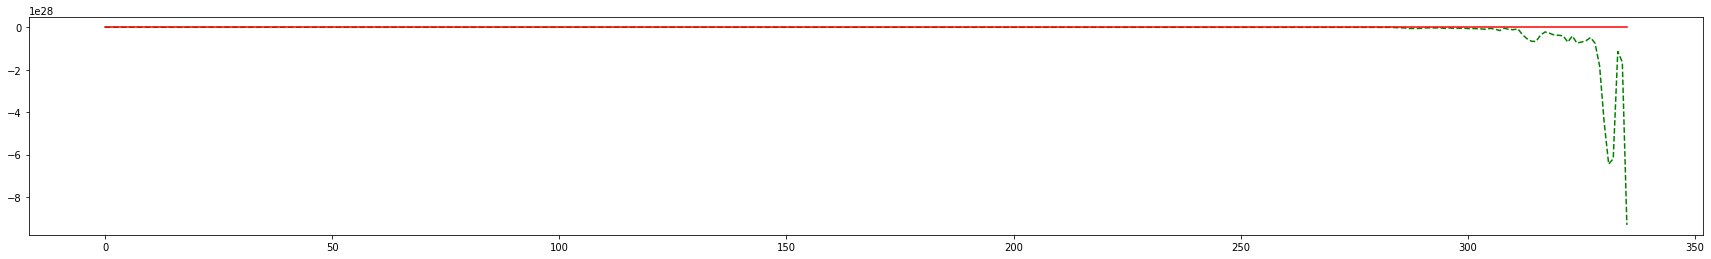

time: 195 ms


In [ ]:
plt.plot( lstm_predictions, 'g--', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

In [ ]:
lstm_model.fit_generator(generator, epochs=10)

#forecast
lstm_predictions_scaled = returnLSTMForecast(lstm_model, sequence_length, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

j = 0
rmseArrayValues = []
while j < len(rmseForecastingPeriodArrays):
  forecastEndIndex = rmseForecastingPeriodArrays[j]
  rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
  rmseArrayValues.append(rmseValue[0])
  j = j + 1
print("RMSE for region ID :", region)
print("Hours:", rmseForecastingPeriodArrays)
print("Values :", rmseArrayValues)
print()

Epoch 1/10
1488/1488 [==============================] - 118s 79ms/step - loss: 0.0020
Epoch 2/10
1488/1488 [==============================] - 117s 78ms/step - loss: 0.0022
Epoch 3/10
1488/1488 [==============================] - 116s 78ms/step - loss: 0.0022
Epoch 4/10
1488/1488 [==============================] - 116s 78ms/step - loss: 0.0022
Epoch 5/10
1488/1488 [==============================] - 117s 79ms/step - loss: 0.0020
Epoch 6/10
1488/1488 [==============================] - 115s 77ms/step - loss: 0.0020
Epoch 7/10
1488/1488 [==============================] - 115s 78ms/step - loss: 0.0020
Epoch 8/10
 445/1488 [=======>......................] - ETA: 1:21 - loss: 0.0020

KeyboardInterrupt: ignored

time: 14min 8s


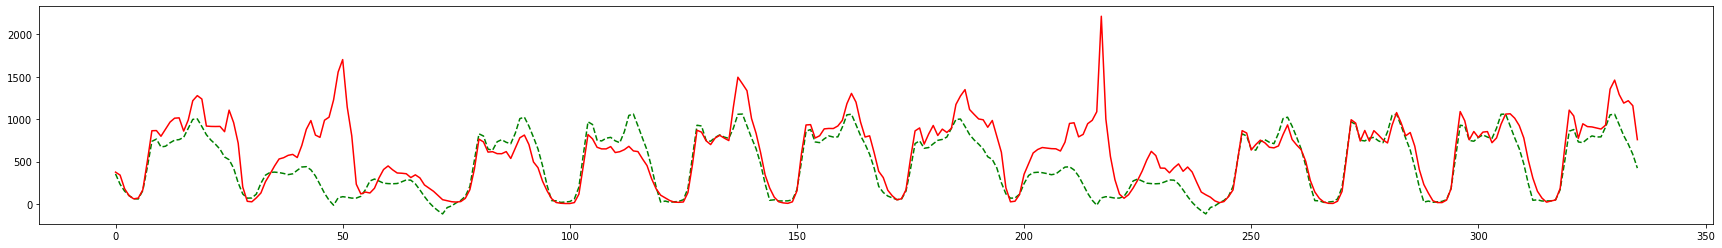

time: 197 ms


In [ ]:
plt.plot( lstm_predictions, 'g--', y_to_test, 'r')
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

## **Putting all together to train the model on all the 20 regions**

In the previous section, we saw some promising results. After some epochs (about 30), and two features (day and hour), the LSTM model beats the best results obtained from the statistical models (precisely TBATS). 

In this section, we train the LSTM model on each region, for each flow, separately. In another section, we try the LSTM model on all the regions combined, new-flows end-flows included.

In [ ]:
import timeSeriesAnalysis
from numpy import array

def returnTrainTestTimeseriesWith2features(regionIDSelected, rawCSVdata, startingIndex, endingIndex, forecastPeriodRange = 24*7*2, newflow = True):
  
  flowTimeSeriesMatrix = []
  if newflow == True:
    flowTimeSeriesMatrix = timeSeriesAnalysis.returnNewFlowTimeSeriesMatrix(rawCSVdata)
  else: 
    flowTimeSeriesMatrix = timeSeriesAnalysis.returnEndFlowTimeSeriesMatrix(rawCSVdata)

  dayTypeEncoding2017 = returnDayTypeArray("2017-01-01")
  hourArray = retourHourArray("2017-01-01")

  regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

  y_to_train = array(flowTimeSeriesMatrix[regionIDIndex][startingIndex:endingIndex])
  y_to_test = array(flowTimeSeriesMatrix[regionIDIndex][endingIndex:endingIndex+forecastPeriodRange])

  y_to_train = y_to_train.reshape(-1, 1)
  y_to_test = y_to_test.reshape(-1, 1)

  #first feature
  weekday_to_train = dayTypeEncoding2017[startingIndex:endingIndex]
  weekday_to_test = dayTypeEncoding2017[endingIndex:endingIndex+forecastPeriodRange]

  #second feature
  hourArray_to_train = hourArray[startingIndex:endIndex]
  hourArray_to_test = hourArray[endIndex:endIndex+forecastPeriodRange]

  return [y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test]


time: 18 ms


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


def returnLSTMModel(hourTrainRange, xtrain, ytrain, batchSize, nfeatures, hiddenStates = 200):
  generator = TimeseriesGenerator(xtrain, ytrain, length=hourTrainRange, batch_size=batchSize)
  lstm_model = Sequential()
  lstm_model.add(LSTM(hiddenStates, activation='relu', input_shape=(hourTrainRange, nfeatures)))
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer='adam', loss='mse')

  return [lstm_model, generator]

def returnBidirectionalLSTMModel(hourTrainRange, xtrain, ytrain, batchSize, nfeatures, nneurons = 200):
  generator = TimeseriesGenerator(xtrain, ytrain, length=hourTrainRange, batch_size=batchSize)
  lstm_model = Sequential()
  lstm_model.add(Bidirectional(LSTM(nneurons, activation='relu'), input_shape=(hourTrainRange, nfeatures)))
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer='adam', loss='mse')

  return [lstm_model, generator]

def returnLSTMForecast(lstm_model, hourTrainRange, nfeatures, forecastPeriodRange, xtrain, featureArray1, featureArray2):
  lstm_predictions_scaled = list()

  batch = xtrain[-hourTrainRange:]

  current_batch = batch.reshape((-1, hourTrainRange, nfeatures))

  j = 0
  for i in range(forecastPeriodRange):   
      lstm_pred = lstm_model.predict(current_batch)[0]
      elem = np.array([lstm_pred[0], featureArray1[j], featureArray2[j]])
      elem = elem.reshape((1, 3))

      lstm_predictions_scaled.append(lstm_pred) 

      current_batch = np.append(current_batch[0] , elem, axis = 0)
      current_batch = current_batch[1:]
      current_batch = current_batch.reshape((-1, hourTrainRange, nfeatures))
      j = j + 1

  return lstm_predictions_scaled

time: 39.1 ms


In [ ]:
from sklearn.preprocessing import MinMaxScaler

#data parameters
startIndex = 24*240
endIndex = 24*303
period_to_forecast = 24*7*2

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#LSTM Parameters
n_input = 24
n_features= 3
batch_size = 1
number_epochs = 30

print("Univariate time series")
print("New-flows forecasting")

for region in regions_selected_array:
  #NEW-FLOW
  #getting the data for the region only
  y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test = returnTrainTestTimeseriesWith2features(region, data, startIndex, endIndex, period_to_forecast) 

  #Scaling and centering
  scaler = MinMaxScaler()
  scaler.fit(y_to_train)
  scaled_train_data = scaler.transform(y_to_train)
  #scaled_test_data = scaler.transform(y_to_test) #not needed

  #input reshaping to include features
  scaled_train_data_copy = scaled_train_data[:]
  scaled_train_data_copy = scaled_train_data_copy.reshape(len(scaled_train_data),)
  scaled_train_data_input = np.stack((scaled_train_data_copy, weekday_to_train, hourArray_to_train), axis=1)

  #creating instance of LSTM model
  lstm_model, generator = returnLSTMModel(n_input, scaled_train_data_input, scaled_train_data, batch_size, n_features)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs, verbose=0)

  #forecast
  lstm_predictions_scaled = returnLSTMForecast(lstm_model, n_input, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

  j = 0
  rmseArrayValues = []
  while j < len(rmseForecastingPeriodArrays):
    forecastEndIndex = rmseForecastingPeriodArrays[j]
    rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
    rmseArrayValues.append(rmseValue[0])
    j = j + 1
  print("RMSE for region ID :", region)
  print("Hours:", rmseForecastingPeriodArrays)
  print("Values :", rmseArrayValues)
  print()


Univariate time series
New-flows forecasting
RMSE for region ID : 26
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [3.5497300309717947, 33.6171646993406, 53.667570451547995, 68.18504287956844, 61.77289859924282, 57.839568177462574, 97.51819151690566, 97.69696580600416]

RMSE for region ID : 53
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [0.585651538322604, 1.2520947905943156, 1.7776721443730044, 1.753702545958345, 1.6336381034863754, 1.6631672532506139, 3.396827945240411, 4.5520485846543455]

RMSE for region ID : 60
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [6.0352370772866735, 11.04553863287478, 10.12415735691162, 12.167604237227387, 13.796274168416144, 33.85992337409228, 58.75107388987216, 55.1836201821783]

RMSE for region ID : 62
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [0.17832834929712593, 0.35159507426506464, 0.36520423593671575, 0.5683696770885087, 0.5633615606019462, 0.5790402008633014, 0.8339754849445172, 0.9645768420854661]

RMSE for region ID : 65

In [ ]:

#data parameters
startIndex = 24*240
endIndex = 24*303
period_to_forecast = 24*7*2

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#LSTM Parameters
n_input = 24
n_features= 3
batch_size = 1
number_epochs = 30

print("Univariate time series")
print("End-flows forecasting")

for region in regions_selected_array:
  #NEW-FLOW
  #getting the data for the region only
  y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test = returnTrainTestTimeseriesWith2features(region, data, startIndex, endIndex, period_to_forecast, False) 

  #Scaling and centering
  scaler = MinMaxScaler()
  scaler.fit(y_to_train)
  scaled_train_data = scaler.transform(y_to_train)
  #scaled_test_data = scaler.transform(y_to_test) #not needed

  #input reshaping to include features
  scaled_train_data_copy = scaled_train_data[:]
  scaled_train_data_copy = scaled_train_data_copy.reshape(len(scaled_train_data),)
  scaled_train_data_input = np.stack((scaled_train_data_copy, weekday_to_train, hourArray_to_train), axis=1)

  #creating instance of LSTM model
  lstm_model, generator = returnLSTMModel(n_input, scaled_train_data_input, scaled_train_data, batch_size, n_features)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs, verbose=0)

  #forecast
  lstm_predictions_scaled = returnLSTMForecast(lstm_model, n_input, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

  j = 0
  rmseArrayValues = []
  while j < len(rmseForecastingPeriodArrays):
    forecastEndIndex = rmseForecastingPeriodArrays[j]
    rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
    rmseArrayValues.append(rmseValue[0])
    j = j + 1
  print("RMSE for region ID :", region)
  print("Hours:", rmseForecastingPeriodArrays)
  print("Values :", rmseArrayValues)
  print()

Univariate time series
End-flows forecasting
RMSE for region ID : 26
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [9.858812960926183, 18.169003665452166, 19.57287344747298, 24.89561153859597, 30.659031860382992, 28.132697612838133, 31.435009772451885, 34.57033546094888]

RMSE for region ID : 53
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [1.4209807085901864, 1.053568013317676, 1.2852743672993618, 1.2037999649035471, 1.3974259693632116, 2.093722695771733, 5.742040886935404, 5.33887876497845]

RMSE for region ID : 60
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [2.8344801921153056, 5.648928029573138, 8.255489306127483, 14.157983873118571, 35.04314376897337, 50.79469557971851, 56.920989288925355, 51.84414508750156]

RMSE for region ID : 62
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [5.703701063371255, 4.206594917268001, 3.864914826282392, 3.427921266847382, 6.1161413372223175, 9.595022006016489, 6.8965606688185614, 6.057541048178139]

RMSE for region ID : 65
Hours: 

ValueError: ignored

time: 2h 38min 41s


In [ ]:
#data parameters
startIndex = 24*240
endIndex = 24*303
period_to_forecast = 24*7*2

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#LSTM Parameters
n_input = 24
n_features= 3
batch_size = 1
number_epochs = 30

print("Univariate time series")
print("End-flows forecasting")

regions_remaining_array = [78, 80, 82, 83, 88, 100, 125]

for region in regions_remaining_array:
  #NEW-FLOW
  #getting the data for the region only
  y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test = returnTrainTestTimeseriesWith2features(region, data, startIndex, endIndex, period_to_forecast, False) 

  #Scaling and centering
  scaler = MinMaxScaler()
  scaler.fit(y_to_train)
  scaled_train_data = scaler.transform(y_to_train)
  #scaled_test_data = scaler.transform(y_to_test) #not needed

  #input reshaping to include features
  scaled_train_data_copy = scaled_train_data[:]
  scaled_train_data_copy = scaled_train_data_copy.reshape(len(scaled_train_data),)
  scaled_train_data_input = np.stack((scaled_train_data_copy, weekday_to_train, hourArray_to_train), axis=1)

  #creating instance of LSTM model
  lstm_model, generator = returnLSTMModel(n_input, scaled_train_data_input, scaled_train_data, batch_size, n_features)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs, verbose=0)

  #forecast
  lstm_predictions_scaled = returnLSTMForecast(lstm_model, n_input, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

  j = 0
  rmseArrayValues = []
  while j < len(rmseForecastingPeriodArrays):
    forecastEndIndex = rmseForecastingPeriodArrays[j]
    rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
    rmseArrayValues.append(rmseValue[0])
    j = j + 1
  print("RMSE for region ID :", region)
  print("Hours:", rmseForecastingPeriodArrays)
  print("Values :", rmseArrayValues)
  print()

Univariate time series
End-flows forecasting
RMSE for region ID : 78
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [24.420529983590566, 27.228739645783296, 62.2998427760606, 90.48350918685573, 93.67905928486336, 96.62056740162262, 58.64270073521568, 71.14749247281618]

RMSE for region ID : 80
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [21.570772735994524, 35.70932049917739, 35.50721387405557, 37.21543257615083, 40.025077503970365, 41.861432835728685, 46.97337417672534, 47.81459963961717]

RMSE for region ID : 82
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [1.568543635173, 2.3284643585521874, 2.9135276508492884, 3.1224290529159453, 3.947297633355204, 5.112238742749358, 8.385433069447107, 7.991727124511933]

RMSE for region ID : 83
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [2.4089506416327526, 21.75262359996228, 21.923640661837805, 36.69460842504243, 41.396790517980364, 40.370490509105046, 26.855500043841417, 25.261364261635467]

RMSE for region ID : 88
Hours: [5

DO region 77 alone because it got out of bound

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#data parameters
startIndex = 24*240
endIndex = 24*303
period_to_forecast = 24*7*2

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#LSTM Parameters
n_input = 24
n_features= 3
batch_size = 1
number_epochs = 35

print("Univariate time series")
print("End-flows forecasting")

for region in [77]:
  #NEW-FLOW
  #getting the data for the region only
  y_to_train, y_to_test, weekday_to_train, weekday_to_test, hourArray_to_train, hourArray_to_test = returnTrainTestTimeseriesWith2features(region, data, startIndex, endIndex, period_to_forecast, False) 

  #Scaling and centering
  scaler = MinMaxScaler()
  scaler.fit(y_to_train)
  scaled_train_data = scaler.transform(y_to_train)
  #scaled_test_data = scaler.transform(y_to_test) #not needed

  #input reshaping to include features
  scaled_train_data_copy = scaled_train_data[:]
  scaled_train_data_copy = scaled_train_data_copy.reshape(len(scaled_train_data),)
  scaled_train_data_input = np.stack((scaled_train_data_copy, weekday_to_train, hourArray_to_train), axis=1)

  #creating instance of LSTM model
  lstm_model, generator = returnLSTMModel(n_input, scaled_train_data_input, scaled_train_data, batch_size, n_features)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs)

  #forecast
  lstm_predictions_scaled = returnLSTMForecast(lstm_model, n_input, n_features, period_to_forecast, scaled_train_data_input, weekday_to_test, hourArray_to_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

  j = 0
  rmseArrayValues = []
  while j < len(rmseForecastingPeriodArrays):
    forecastEndIndex = rmseForecastingPeriodArrays[j]
    rmseValue = returnRMSEFor(y_to_test[:forecastEndIndex], lstm_predictions[:forecastEndIndex])
    rmseArrayValues.append(rmseValue[0])
    j = j + 1
  print("RMSE for region ID :", region)
  print("Hours:", rmseForecastingPeriodArrays)
  print("Values :", rmseArrayValues)
  print()

In [ ]:
j = 0
rmseArrayValues = []
while j < len(rmseForecastingPeriodArrays):
  forecastEndIndex = rmseForecastingPeriodArrays[j]
  rmseValue = returnRMSEFor(lstm_predictions[:forecastEndIndex], y_to_test[:forecastEndIndex])
  rmseArrayValues.append(rmseValue[0])
  j = j + 1
print("RMSE for region ID :", region)
print("Hours:", rmseForecastingPeriodArrays)
print("Values :", rmseArrayValues)
print()

RMSE for region ID : 77
Hours: [5, 10, 12, 16, 20, 24, 168, 336]
Values : [16.62486577080944, 105.98597377409094, 127.24590422065793, 130.22028403670262, 162.08065226276457, 159.91034726329264, 78.43220134964916, 74.86084952403523]

time: 6.55 ms


In [ ]:
regionIDSelected = 77

startIndex = 24*230
endIndex = 24*303
periodtoforecast = 24*7*2
regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

newflows = endFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+periodtoforecast]

average = np.sum(newflows) / len(newflows)

print(average)

264.9017857142857
time: 5.91 ms


In [ ]:
def plotForecastAgaintRealTimeSeries(predictionTimeSeries, targetTimeSeries, figuresize):
  plt.figure(figsize=(figuresize[0],figuresize[1]))
  plt.xlabel("Time in hour") 
  plt.ylabel("Number of taxi trips") 
  plt.title("Forecast in green against actual time series in red")
  plt.plot(predictionTimeSeries,'g', targetTimeSeries, 'r') 
  plt.show()

time: 3.9 ms


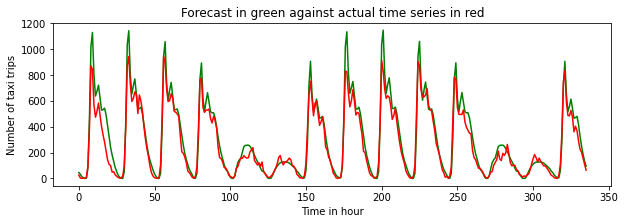

time: 311 ms


In [ ]:
plotForecastAgaintRealTimeSeries(lstm_predictions, y_to_test, [10,3])

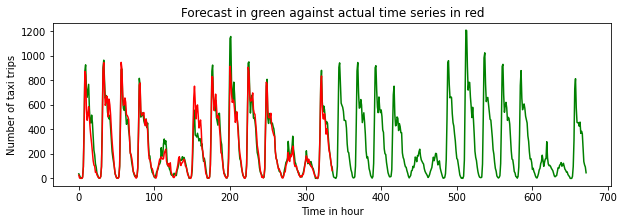

time: 173 ms


In [ ]:

plotForecastAgaintRealTimeSeries(y_to_train[-336*2:], y_to_test, [10,3])